In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [5]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-05-24 20:32:48.471376: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_02_bin1     2676486
                     ...   
TiteSeq_15_bin4      401678
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [10]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mp_list = [mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [12]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)
inputs in build shape = (None, 5)


In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4285)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4221)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4222        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 74,560 observations set as training data.
Using 19.7% for validation.
Time to set data: 15.5 sec.


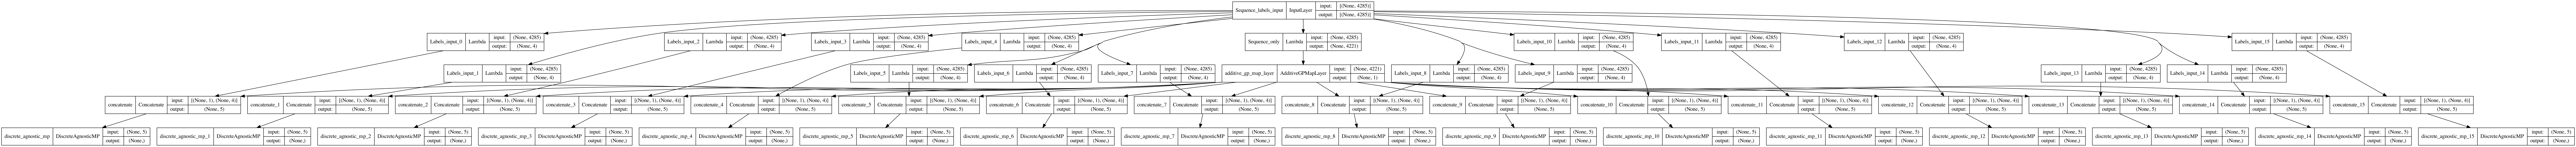

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='titeseq_dar.png')

In [17]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=1000,
          batch_size=500,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/1000
120/120 [==============================] - 16s 57ms/step - loss: 1209890.8750 - discrete_agnostic_mp_loss: 73988.8125 - discrete_agnostic_mp_1_loss: 78039.0234 - discrete_agnostic_mp_2_loss: 79923.0547 - discrete_agnostic_mp_3_loss: 89432.2188 - discrete_agnostic_mp_4_loss: 84896.0703 - discrete_agnostic_mp_5_loss: 92882.6641 - discrete_agnostic_mp_6_loss: 87487.7422 - discrete_agnostic_mp_7_loss: 88538.6719 - discrete_agnostic_mp_8_loss: 80291.7734 - discrete_agnostic_mp_9_loss: 74718.7109 - discrete_agnostic_mp_10_loss: 83221.4922 - discrete_agnostic_mp_11_loss: 90707.3750 - discrete_agnostic_mp_12_loss: 53456.1328 - discrete_agnostic_mp_13_loss: 51570.5430 - discrete_agnostic_mp_14_loss: 47060.7695 - discrete_agnostic_mp_15_loss: 53675.7617 - I_var: -0.2158 - val_loss: 1114946.2500 - val_discrete_agnostic_mp_loss: 70661.7109 - val_discrete_agnostic_mp_1_loss: 74652.5938 - val_discrete_agnostic_mp_2_loss: 76813.5859 - val_discrete_agnostic_mp_3_loss: 85884.2031 - val_dis

120/120 [==============================] - 4s 34ms/step - loss: 1119856.8750 - discrete_agnostic_mp_loss: 72599.5156 - discrete_agnostic_mp_1_loss: 77063.8359 - discrete_agnostic_mp_2_loss: 79004.6250 - discrete_agnostic_mp_3_loss: 88778.4453 - discrete_agnostic_mp_4_loss: 83213.3828 - discrete_agnostic_mp_5_loss: 91833.7969 - discrete_agnostic_mp_6_loss: 86142.0469 - discrete_agnostic_mp_7_loss: 87614.6953 - discrete_agnostic_mp_8_loss: 78932.5938 - discrete_agnostic_mp_9_loss: 66601.0469 - discrete_agnostic_mp_10_loss: 71043.9219 - discrete_agnostic_mp_11_loss: 79514.6953 - discrete_agnostic_mp_12_loss: 39570.6602 - discrete_agnostic_mp_13_loss: 36533.2539 - discrete_agnostic_mp_14_loss: 38759.3438 - discrete_agnostic_mp_15_loss: 42650.9570 - I_var: 0.0043 - val_loss: 1117335.6250 - val_discrete_agnostic_mp_loss: 70974.8516 - val_discrete_agnostic_mp_1_loss: 74935.5234 - val_discrete_agnostic_mp_2_loss: 77206.7266 - val_discrete_agnostic_mp_3_loss: 86216.5391 - val_discrete_agnostic_

120/120 [==============================] - 4s 34ms/step - loss: 1119023.0000 - discrete_agnostic_mp_loss: 72513.3203 - discrete_agnostic_mp_1_loss: 76976.7109 - discrete_agnostic_mp_2_loss: 78944.6484 - discrete_agnostic_mp_3_loss: 88688.2656 - discrete_agnostic_mp_4_loss: 83111.3438 - discrete_agnostic_mp_5_loss: 91736.9922 - discrete_agnostic_mp_6_loss: 86047.9922 - discrete_agnostic_mp_7_loss: 87557.4531 - discrete_agnostic_mp_8_loss: 78851.6250 - discrete_agnostic_mp_9_loss: 66533.1562 - discrete_agnostic_mp_10_loss: 71003.6953 - discrete_agnostic_mp_11_loss: 79482.3828 - discrete_agnostic_mp_12_loss: 39601.3867 - discrete_agnostic_mp_13_loss: 36531.4844 - discrete_agnostic_mp_14_loss: 38773.8164 - discrete_agnostic_mp_15_loss: 42668.7305 - I_var: 0.0039 - val_loss: 1123717.0000 - val_discrete_agnostic_mp_loss: 71262.0469 - val_discrete_agnostic_mp_1_loss: 75257.1875 - val_discrete_agnostic_mp_2_loss: 77583.2031 - val_discrete_agnostic_mp_3_loss: 86535.2500 - val_discrete_agnostic_

120/120 [==============================] - 5s 38ms/step - loss: 1119699.5000 - discrete_agnostic_mp_loss: 72390.7109 - discrete_agnostic_mp_1_loss: 76858.7031 - discrete_agnostic_mp_2_loss: 78817.3516 - discrete_agnostic_mp_3_loss: 88624.7031 - discrete_agnostic_mp_4_loss: 83043.4141 - discrete_agnostic_mp_5_loss: 91716.6719 - discrete_agnostic_mp_6_loss: 86145.0469 - discrete_agnostic_mp_7_loss: 87696.5547 - discrete_agnostic_mp_8_loss: 79089.8594 - discrete_agnostic_mp_9_loss: 66701.6094 - discrete_agnostic_mp_10_loss: 71190.4766 - discrete_agnostic_mp_11_loss: 79716.6250 - discrete_agnostic_mp_12_loss: 39697.0820 - discrete_agnostic_mp_13_loss: 36626.9219 - discrete_agnostic_mp_14_loss: 38818.6758 - discrete_agnostic_mp_15_loss: 42564.8477 - I_var: 0.0074 - val_loss: 1110337.1250 - val_discrete_agnostic_mp_loss: 70242.6250 - val_discrete_agnostic_mp_1_loss: 74284.9766 - val_discrete_agnostic_mp_2_loss: 76529.1953 - val_discrete_agnostic_mp_3_loss: 85465.0156 - val_discrete_agnostic_

120/120 [==============================] - 5s 38ms/step - loss: 1109976.1250 - discrete_agnostic_mp_loss: 70617.3516 - discrete_agnostic_mp_1_loss: 75184.9844 - discrete_agnostic_mp_2_loss: 77136.8359 - discrete_agnostic_mp_3_loss: 86959.1016 - discrete_agnostic_mp_4_loss: 81450.5156 - discrete_agnostic_mp_5_loss: 90382.9453 - discrete_agnostic_mp_6_loss: 85339.8594 - discrete_agnostic_mp_7_loss: 87244.9531 - discrete_agnostic_mp_8_loss: 79027.0156 - discrete_agnostic_mp_9_loss: 66769.6172 - discrete_agnostic_mp_10_loss: 71335.0625 - discrete_agnostic_mp_11_loss: 80163.9062 - discrete_agnostic_mp_12_loss: 40004.1914 - discrete_agnostic_mp_13_loss: 36850.6953 - discrete_agnostic_mp_14_loss: 38966.9375 - discrete_agnostic_mp_15_loss: 42542.2148 - I_var: 0.0080 - val_loss: 1102961.8750 - val_discrete_agnostic_mp_loss: 69002.6094 - val_discrete_agnostic_mp_1_loss: 73048.4844 - val_discrete_agnostic_mp_2_loss: 75388.1328 - val_discrete_agnostic_mp_3_loss: 84178.8438 - val_discrete_agnostic_

120/120 [==============================] - 4s 34ms/step - loss: 1049599.7500 - discrete_agnostic_mp_loss: 63425.5898 - discrete_agnostic_mp_1_loss: 68038.6641 - discrete_agnostic_mp_2_loss: 70550.8984 - discrete_agnostic_mp_3_loss: 79006.4844 - discrete_agnostic_mp_4_loss: 73622.8203 - discrete_agnostic_mp_5_loss: 82505.4453 - discrete_agnostic_mp_6_loss: 78727.4609 - discrete_agnostic_mp_7_loss: 81952.6719 - discrete_agnostic_mp_8_loss: 76274.6797 - discrete_agnostic_mp_9_loss: 63741.5820 - discrete_agnostic_mp_10_loss: 71257.3359 - discrete_agnostic_mp_11_loss: 80065.0234 - discrete_agnostic_mp_12_loss: 40435.9180 - discrete_agnostic_mp_13_loss: 37295.5742 - discrete_agnostic_mp_14_loss: 39440.6172 - discrete_agnostic_mp_15_loss: 43258.5586 - I_var: -0.0049 - val_loss: 1057414.8750 - val_discrete_agnostic_mp_loss: 63406.7422 - val_discrete_agnostic_mp_1_loss: 67460.2500 - val_discrete_agnostic_mp_2_loss: 70724.4766 - val_discrete_agnostic_mp_3_loss: 77933.0078 - val_discrete_agnostic

120/120 [==============================] - 4s 36ms/step - loss: 928645.4375 - discrete_agnostic_mp_loss: 52692.7500 - discrete_agnostic_mp_1_loss: 57474.4336 - discrete_agnostic_mp_2_loss: 62206.6211 - discrete_agnostic_mp_3_loss: 65408.4648 - discrete_agnostic_mp_4_loss: 61335.7500 - discrete_agnostic_mp_5_loss: 69697.1250 - discrete_agnostic_mp_6_loss: 66525.6328 - discrete_agnostic_mp_7_loss: 69235.4141 - discrete_agnostic_mp_8_loss: 65898.5469 - discrete_agnostic_mp_9_loss: 56627.4414 - discrete_agnostic_mp_10_loss: 69192.3359 - discrete_agnostic_mp_11_loss: 74912.9609 - discrete_agnostic_mp_12_loss: 38978.1953 - discrete_agnostic_mp_13_loss: 36167.0703 - discrete_agnostic_mp_14_loss: 38839.3516 - discrete_agnostic_mp_15_loss: 43453.0391 - I_var: -0.0105 - val_loss: 958658.8750 - val_discrete_agnostic_mp_loss: 54586.3477 - val_discrete_agnostic_mp_1_loss: 58873.5117 - val_discrete_agnostic_mp_2_loss: 63873.2617 - val_discrete_agnostic_mp_3_loss: 67064.0938 - val_discrete_agnostic_m

120/120 [==============================] - 4s 34ms/step - loss: 876997.6250 - discrete_agnostic_mp_loss: 48491.7812 - discrete_agnostic_mp_1_loss: 53685.9688 - discrete_agnostic_mp_2_loss: 59476.6602 - discrete_agnostic_mp_3_loss: 59708.6016 - discrete_agnostic_mp_4_loss: 56626.3984 - discrete_agnostic_mp_5_loss: 64580.3086 - discrete_agnostic_mp_6_loss: 61091.4375 - discrete_agnostic_mp_7_loss: 63575.4570 - discrete_agnostic_mp_8_loss: 60847.4883 - discrete_agnostic_mp_9_loss: 53480.7188 - discrete_agnostic_mp_10_loss: 66854.4844 - discrete_agnostic_mp_11_loss: 72719.4922 - discrete_agnostic_mp_12_loss: 38552.3555 - discrete_agnostic_mp_13_loss: 35722.8359 - discrete_agnostic_mp_14_loss: 38588.0586 - discrete_agnostic_mp_15_loss: 42995.2305 - I_var: -0.0023 - val_loss: 904267.6875 - val_discrete_agnostic_mp_loss: 49719.2070 - val_discrete_agnostic_mp_1_loss: 54448.1602 - val_discrete_agnostic_mp_2_loss: 60409.3945 - val_discrete_agnostic_mp_3_loss: 60815.0000 - val_discrete_agnostic_m

120/120 [==============================] - 6s 47ms/step - loss: 846653.3750 - discrete_agnostic_mp_loss: 46280.1602 - discrete_agnostic_mp_1_loss: 51714.7695 - discrete_agnostic_mp_2_loss: 57890.2188 - discrete_agnostic_mp_3_loss: 56490.1992 - discrete_agnostic_mp_4_loss: 54066.9219 - discrete_agnostic_mp_5_loss: 61429.1367 - discrete_agnostic_mp_6_loss: 57674.5664 - discrete_agnostic_mp_7_loss: 60251.2539 - discrete_agnostic_mp_8_loss: 57597.1953 - discrete_agnostic_mp_9_loss: 51425.5430 - discrete_agnostic_mp_10_loss: 65236.3125 - discrete_agnostic_mp_11_loss: 71439.6797 - discrete_agnostic_mp_12_loss: 38294.8320 - discrete_agnostic_mp_13_loss: 35546.2031 - discrete_agnostic_mp_14_loss: 38405.6797 - discrete_agnostic_mp_15_loss: 42910.3711 - I_var: -1.4229e-04 - val_loss: 864593.1875 - val_discrete_agnostic_mp_loss: 47038.6602 - val_discrete_agnostic_mp_1_loss: 51917.5430 - val_discrete_agnostic_mp_2_loss: 57914.6992 - val_discrete_agnostic_mp_3_loss: 56799.6367 - val_discrete_agnost

120/120 [==============================] - 4s 35ms/step - loss: 832893.5000 - discrete_agnostic_mp_loss: 45469.6133 - discrete_agnostic_mp_1_loss: 51009.4414 - discrete_agnostic_mp_2_loss: 57340.0547 - discrete_agnostic_mp_3_loss: 55203.5039 - discrete_agnostic_mp_4_loss: 53104.1797 - discrete_agnostic_mp_5_loss: 60095.7734 - discrete_agnostic_mp_6_loss: 56086.2188 - discrete_agnostic_mp_7_loss: 58649.5859 - discrete_agnostic_mp_8_loss: 55801.1797 - discrete_agnostic_mp_9_loss: 50301.5820 - discrete_agnostic_mp_10_loss: 64371.7422 - discrete_agnostic_mp_11_loss: 70653.5859 - discrete_agnostic_mp_12_loss: 38156.3672 - discrete_agnostic_mp_13_loss: 35488.9727 - discrete_agnostic_mp_14_loss: 38320.4336 - discrete_agnostic_mp_15_loss: 42840.9297 - I_var: 0.0052 - val_loss: 845147.8750 - val_discrete_agnostic_mp_loss: 45355.5117 - val_discrete_agnostic_mp_1_loss: 50532.2969 - val_discrete_agnostic_mp_2_loss: 56971.8125 - val_discrete_agnostic_mp_3_loss: 54792.7539 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 36ms/step - loss: 821714.3750 - discrete_agnostic_mp_loss: 44825.2031 - discrete_agnostic_mp_1_loss: 50368.5781 - discrete_agnostic_mp_2_loss: 56864.4609 - discrete_agnostic_mp_3_loss: 54202.1523 - discrete_agnostic_mp_4_loss: 52303.6055 - discrete_agnostic_mp_5_loss: 59049.0430 - discrete_agnostic_mp_6_loss: 54772.2148 - discrete_agnostic_mp_7_loss: 57505.9258 - discrete_agnostic_mp_8_loss: 54425.8555 - discrete_agnostic_mp_9_loss: 49380.3008 - discrete_agnostic_mp_10_loss: 63740.9609 - discrete_agnostic_mp_11_loss: 69844.4062 - discrete_agnostic_mp_12_loss: 38040.2852 - discrete_agnostic_mp_13_loss: 35405.8242 - discrete_agnostic_mp_14_loss: 38234.2148 - discrete_agnostic_mp_15_loss: 42750.9844 - I_var: 0.0057 - val_loss: 829396.5000 - val_discrete_agnostic_mp_loss: 44335.0898 - val_discrete_agnostic_mp_1_loss: 49452.8281 - val_discrete_agnostic_mp_2_loss: 55973.6719 - val_discrete_agnostic_mp_3_loss: 53070.4766 - val_discrete_agnostic_mp

120/120 [==============================] - 6s 47ms/step - loss: 813322.3750 - discrete_agnostic_mp_loss: 44429.3008 - discrete_agnostic_mp_1_loss: 49918.0781 - discrete_agnostic_mp_2_loss: 56546.4961 - discrete_agnostic_mp_3_loss: 53604.1836 - discrete_agnostic_mp_4_loss: 51802.1562 - discrete_agnostic_mp_5_loss: 58303.4570 - discrete_agnostic_mp_6_loss: 53817.7539 - discrete_agnostic_mp_7_loss: 56629.6445 - discrete_agnostic_mp_8_loss: 53205.4297 - discrete_agnostic_mp_9_loss: 48688.5664 - discrete_agnostic_mp_10_loss: 63201.1055 - discrete_agnostic_mp_11_loss: 69149.0391 - discrete_agnostic_mp_12_loss: 37904.3477 - discrete_agnostic_mp_13_loss: 35339.0117 - discrete_agnostic_mp_14_loss: 38144.4688 - discrete_agnostic_mp_15_loss: 42639.0273 - I_var: 0.0047 - val_loss: 823835.5000 - val_discrete_agnostic_mp_loss: 44113.3477 - val_discrete_agnostic_mp_1_loss: 49093.3047 - val_discrete_agnostic_mp_2_loss: 55725.6797 - val_discrete_agnostic_mp_3_loss: 52655.5938 - val_discrete_agnostic_mp

120/120 [==============================] - 7s 62ms/step - loss: 808527.1250 - discrete_agnostic_mp_loss: 44212.4375 - discrete_agnostic_mp_1_loss: 49593.0391 - discrete_agnostic_mp_2_loss: 56409.9844 - discrete_agnostic_mp_3_loss: 53229.7461 - discrete_agnostic_mp_4_loss: 51474.3125 - discrete_agnostic_mp_5_loss: 57962.4531 - discrete_agnostic_mp_6_loss: 53356.0156 - discrete_agnostic_mp_7_loss: 56131.0977 - discrete_agnostic_mp_8_loss: 52310.3672 - discrete_agnostic_mp_9_loss: 48288.3477 - discrete_agnostic_mp_10_loss: 62900.3750 - discrete_agnostic_mp_11_loss: 68709.9141 - discrete_agnostic_mp_12_loss: 37861.0938 - discrete_agnostic_mp_13_loss: 35319.0469 - discrete_agnostic_mp_14_loss: 38097.9648 - discrete_agnostic_mp_15_loss: 42670.6172 - I_var: 0.0067 - val_loss: 815972.5000 - val_discrete_agnostic_mp_loss: 43363.3750 - val_discrete_agnostic_mp_1_loss: 48285.0625 - val_discrete_agnostic_mp_2_loss: 55229.6875 - val_discrete_agnostic_mp_3_loss: 51674.7227 - val_discrete_agnostic_mp

120/120 [==============================] - 8s 68ms/step - loss: 804020.7500 - discrete_agnostic_mp_loss: 43985.6211 - discrete_agnostic_mp_1_loss: 49151.1094 - discrete_agnostic_mp_2_loss: 56252.4258 - discrete_agnostic_mp_3_loss: 52909.6406 - discrete_agnostic_mp_4_loss: 51116.9375 - discrete_agnostic_mp_5_loss: 57638.8359 - discrete_agnostic_mp_6_loss: 53032.9453 - discrete_agnostic_mp_7_loss: 55664.9062 - discrete_agnostic_mp_8_loss: 51515.9219 - discrete_agnostic_mp_9_loss: 47954.9766 - discrete_agnostic_mp_10_loss: 62623.8359 - discrete_agnostic_mp_11_loss: 68340.1719 - discrete_agnostic_mp_12_loss: 37806.1719 - discrete_agnostic_mp_13_loss: 35297.0312 - discrete_agnostic_mp_14_loss: 38086.8711 - discrete_agnostic_mp_15_loss: 42642.8828 - I_var: 0.0065 - val_loss: 809623.1250 - val_discrete_agnostic_mp_loss: 43092.0039 - val_discrete_agnostic_mp_1_loss: 47776.9180 - val_discrete_agnostic_mp_2_loss: 55020.7891 - val_discrete_agnostic_mp_3_loss: 51239.9453 - val_discrete_agnostic_mp

120/120 [==============================] - 7s 62ms/step - loss: 798080.1875 - discrete_agnostic_mp_loss: 43656.1953 - discrete_agnostic_mp_1_loss: 48448.3711 - discrete_agnostic_mp_2_loss: 55946.2891 - discrete_agnostic_mp_3_loss: 52351.9062 - discrete_agnostic_mp_4_loss: 50495.9766 - discrete_agnostic_mp_5_loss: 57197.5039 - discrete_agnostic_mp_6_loss: 52723.1836 - discrete_agnostic_mp_7_loss: 55004.4375 - discrete_agnostic_mp_8_loss: 50725.1641 - discrete_agnostic_mp_9_loss: 47565.4688 - discrete_agnostic_mp_10_loss: 62369.1719 - discrete_agnostic_mp_11_loss: 67970.4141 - discrete_agnostic_mp_12_loss: 37737.7969 - discrete_agnostic_mp_13_loss: 35264.3164 - discrete_agnostic_mp_14_loss: 38037.0859 - discrete_agnostic_mp_15_loss: 42586.8555 - I_var: 0.0054 - val_loss: 804205.0625 - val_discrete_agnostic_mp_loss: 42677.1367 - val_discrete_agnostic_mp_1_loss: 47079.0977 - val_discrete_agnostic_mp_2_loss: 54821.7188 - val_discrete_agnostic_mp_3_loss: 50679.6133 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 791891.2500 - discrete_agnostic_mp_loss: 43283.7383 - discrete_agnostic_mp_1_loss: 47645.7422 - discrete_agnostic_mp_2_loss: 55713.8086 - discrete_agnostic_mp_3_loss: 51720.8711 - discrete_agnostic_mp_4_loss: 49783.6992 - discrete_agnostic_mp_5_loss: 56696.3750 - discrete_agnostic_mp_6_loss: 52260.6484 - discrete_agnostic_mp_7_loss: 54114.6641 - discrete_agnostic_mp_8_loss: 49942.9062 - discrete_agnostic_mp_9_loss: 47183.1172 - discrete_agnostic_mp_10_loss: 62204.2500 - discrete_agnostic_mp_11_loss: 67677.6250 - discrete_agnostic_mp_12_loss: 37720.5352 - discrete_agnostic_mp_13_loss: 35259.9531 - discrete_agnostic_mp_14_loss: 38035.5938 - discrete_agnostic_mp_15_loss: 42647.4219 - I_var: 0.0081 - val_loss: 796152.8750 - val_discrete_agnostic_mp_loss: 42194.9531 - val_discrete_agnostic_mp_1_loss: 46181.4453 - val_discrete_agnostic_mp_2_loss: 54459.0078 - val_discrete_agnostic_mp_3_loss: 49975.4609 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 38ms/step - loss: 783757.1250 - discrete_agnostic_mp_loss: 42718.1875 - discrete_agnostic_mp_1_loss: 46574.0391 - discrete_agnostic_mp_2_loss: 55260.4297 - discrete_agnostic_mp_3_loss: 50738.0391 - discrete_agnostic_mp_4_loss: 48705.3320 - discrete_agnostic_mp_5_loss: 55807.9023 - discrete_agnostic_mp_6_loss: 51708.3242 - discrete_agnostic_mp_7_loss: 53052.4414 - discrete_agnostic_mp_8_loss: 49350.7344 - discrete_agnostic_mp_9_loss: 46824.5234 - discrete_agnostic_mp_10_loss: 62045.6055 - discrete_agnostic_mp_11_loss: 67418.3984 - discrete_agnostic_mp_12_loss: 37678.2539 - discrete_agnostic_mp_13_loss: 35246.9414 - discrete_agnostic_mp_14_loss: 38014.4961 - discrete_agnostic_mp_15_loss: 42613.0078 - I_var: 0.0037 - val_loss: 788515.2500 - val_discrete_agnostic_mp_loss: 41609.8477 - val_discrete_agnostic_mp_1_loss: 45098.9023 - val_discrete_agnostic_mp_2_loss: 54021.9570 - val_discrete_agnostic_mp_3_loss: 49035.8477 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 776689.3750 - discrete_agnostic_mp_loss: 42161.2188 - discrete_agnostic_mp_1_loss: 45600.5117 - discrete_agnostic_mp_2_loss: 54839.7422 - discrete_agnostic_mp_3_loss: 49855.8477 - discrete_agnostic_mp_4_loss: 47728.7070 - discrete_agnostic_mp_5_loss: 54836.2461 - discrete_agnostic_mp_6_loss: 51140.6367 - discrete_agnostic_mp_7_loss: 52200.3516 - discrete_agnostic_mp_8_loss: 48891.2422 - discrete_agnostic_mp_9_loss: 46599.1602 - discrete_agnostic_mp_10_loss: 62008.9922 - discrete_agnostic_mp_11_loss: 67342.7422 - discrete_agnostic_mp_12_loss: 37657.5273 - discrete_agnostic_mp_13_loss: 35227.8125 - discrete_agnostic_mp_14_loss: 38001.8711 - discrete_agnostic_mp_15_loss: 42596.2773 - I_var: 0.0040 - val_loss: 807068.8750 - val_discrete_agnostic_mp_loss: 42783.5078 - val_discrete_agnostic_mp_1_loss: 45778.0664 - val_discrete_agnostic_mp_2_loss: 54513.0039 - val_discrete_agnostic_mp_3_loss: 50401.9883 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 42ms/step - loss: 767776.7500 - discrete_agnostic_mp_loss: 41274.6211 - discrete_agnostic_mp_1_loss: 44482.7500 - discrete_agnostic_mp_2_loss: 54146.7656 - discrete_agnostic_mp_3_loss: 48651.5977 - discrete_agnostic_mp_4_loss: 46475.8281 - discrete_agnostic_mp_5_loss: 53551.0547 - discrete_agnostic_mp_6_loss: 50271.4570 - discrete_agnostic_mp_7_loss: 51611.0430 - discrete_agnostic_mp_8_loss: 48423.8086 - discrete_agnostic_mp_9_loss: 46332.5664 - discrete_agnostic_mp_10_loss: 61891.5273 - discrete_agnostic_mp_11_loss: 67225.3125 - discrete_agnostic_mp_12_loss: 37652.6523 - discrete_agnostic_mp_13_loss: 35219.0234 - discrete_agnostic_mp_14_loss: 37984.8203 - discrete_agnostic_mp_15_loss: 42581.1680 - I_var: 0.0055 - val_loss: 772218.8750 - val_discrete_agnostic_mp_loss: 40207.0938 - val_discrete_agnostic_mp_1_loss: 43140.0898 - val_discrete_agnostic_mp_2_loss: 52874.8242 - val_discrete_agnostic_mp_3_loss: 46950.1016 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 43ms/step - loss: 761064.0000 - discrete_agnostic_mp_loss: 40526.5664 - discrete_agnostic_mp_1_loss: 43736.5156 - discrete_agnostic_mp_2_loss: 53649.5117 - discrete_agnostic_mp_3_loss: 47796.5078 - discrete_agnostic_mp_4_loss: 45543.0391 - discrete_agnostic_mp_5_loss: 52568.9922 - discrete_agnostic_mp_6_loss: 49369.2773 - discrete_agnostic_mp_7_loss: 51359.3867 - discrete_agnostic_mp_8_loss: 47950.0234 - discrete_agnostic_mp_9_loss: 46113.3945 - discrete_agnostic_mp_10_loss: 61881.3242 - discrete_agnostic_mp_11_loss: 67152.9219 - discrete_agnostic_mp_12_loss: 37632.9375 - discrete_agnostic_mp_13_loss: 35222.9648 - discrete_agnostic_mp_14_loss: 37980.5703 - discrete_agnostic_mp_15_loss: 42579.5000 - I_var: 0.0069 - val_loss: 767856.5000 - val_discrete_agnostic_mp_loss: 39653.1016 - val_discrete_agnostic_mp_1_loss: 42648.1250 - val_discrete_agnostic_mp_2_loss: 52471.8906 - val_discrete_agnostic_mp_3_loss: 46396.3320 - val_discrete_agnostic_mp

120/120 [==============================] - 7s 58ms/step - loss: 755650.7500 - discrete_agnostic_mp_loss: 39778.9414 - discrete_agnostic_mp_1_loss: 43120.0742 - discrete_agnostic_mp_2_loss: 53120.4805 - discrete_agnostic_mp_3_loss: 47110.8125 - discrete_agnostic_mp_4_loss: 44792.3086 - discrete_agnostic_mp_5_loss: 51871.2578 - discrete_agnostic_mp_6_loss: 48597.1523 - discrete_agnostic_mp_7_loss: 51301.0547 - discrete_agnostic_mp_8_loss: 47673.2969 - discrete_agnostic_mp_9_loss: 45998.6758 - discrete_agnostic_mp_10_loss: 61789.5117 - discrete_agnostic_mp_11_loss: 67088.4844 - discrete_agnostic_mp_12_loss: 37627.4609 - discrete_agnostic_mp_13_loss: 35203.8555 - discrete_agnostic_mp_14_loss: 37971.7578 - discrete_agnostic_mp_15_loss: 42604.8125 - I_var: 0.0044 - val_loss: 759944.8750 - val_discrete_agnostic_mp_loss: 38699.1680 - val_discrete_agnostic_mp_1_loss: 41821.7852 - val_discrete_agnostic_mp_2_loss: 51898.7578 - val_discrete_agnostic_mp_3_loss: 45341.7344 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 36ms/step - loss: 751743.1875 - discrete_agnostic_mp_loss: 39280.3164 - discrete_agnostic_mp_1_loss: 42771.4180 - discrete_agnostic_mp_2_loss: 52787.3086 - discrete_agnostic_mp_3_loss: 46707.8086 - discrete_agnostic_mp_4_loss: 44375.2656 - discrete_agnostic_mp_5_loss: 51382.6445 - discrete_agnostic_mp_6_loss: 47901.0195 - discrete_agnostic_mp_7_loss: 51160.1523 - discrete_agnostic_mp_8_loss: 47256.7031 - discrete_agnostic_mp_9_loss: 45896.3789 - discrete_agnostic_mp_10_loss: 61749.2305 - discrete_agnostic_mp_11_loss: 67064.4844 - discrete_agnostic_mp_12_loss: 37618.3086 - discrete_agnostic_mp_13_loss: 35205.1367 - discrete_agnostic_mp_14_loss: 37977.1797 - discrete_agnostic_mp_15_loss: 42609.2305 - I_var: 0.0045 - val_loss: 756745.2500 - val_discrete_agnostic_mp_loss: 38177.8125 - val_discrete_agnostic_mp_1_loss: 41452.5508 - val_discrete_agnostic_mp_2_loss: 51533.5078 - val_discrete_agnostic_mp_3_loss: 44927.9375 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 749860.1875 - discrete_agnostic_mp_loss: 38956.3594 - discrete_agnostic_mp_1_loss: 42544.5273 - discrete_agnostic_mp_2_loss: 52496.2461 - discrete_agnostic_mp_3_loss: 46477.9883 - discrete_agnostic_mp_4_loss: 44110.8008 - discrete_agnostic_mp_5_loss: 51210.7383 - discrete_agnostic_mp_6_loss: 47635.0508 - discrete_agnostic_mp_7_loss: 51213.7930 - discrete_agnostic_mp_8_loss: 47129.9883 - discrete_agnostic_mp_9_loss: 45917.7344 - discrete_agnostic_mp_10_loss: 61800.4727 - discrete_agnostic_mp_11_loss: 67015.9375 - discrete_agnostic_mp_12_loss: 37613.5547 - discrete_agnostic_mp_13_loss: 35198.1914 - discrete_agnostic_mp_14_loss: 37938.2812 - discrete_agnostic_mp_15_loss: 42599.8828 - I_var: 0.0061 - val_loss: 753802.6250 - val_discrete_agnostic_mp_loss: 37823.7188 - val_discrete_agnostic_mp_1_loss: 41168.3086 - val_discrete_agnostic_mp_2_loss: 51204.1992 - val_discrete_agnostic_mp_3_loss: 44590.7578 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 748129.0000 - discrete_agnostic_mp_loss: 38673.8516 - discrete_agnostic_mp_1_loss: 42300.7930 - discrete_agnostic_mp_2_loss: 52208.9062 - discrete_agnostic_mp_3_loss: 46233.2344 - discrete_agnostic_mp_4_loss: 43864.0547 - discrete_agnostic_mp_5_loss: 50970.6875 - discrete_agnostic_mp_6_loss: 47395.5234 - discrete_agnostic_mp_7_loss: 51238.6406 - discrete_agnostic_mp_8_loss: 47036.8477 - discrete_agnostic_mp_9_loss: 45970.1211 - discrete_agnostic_mp_10_loss: 61785.4883 - discrete_agnostic_mp_11_loss: 67063.7891 - discrete_agnostic_mp_12_loss: 37626.7422 - discrete_agnostic_mp_13_loss: 35206.3789 - discrete_agnostic_mp_14_loss: 37963.5508 - discrete_agnostic_mp_15_loss: 42589.6641 - I_var: 0.0068 - val_loss: 759040.6875 - val_discrete_agnostic_mp_loss: 38018.1875 - val_discrete_agnostic_mp_1_loss: 41401.4766 - val_discrete_agnostic_mp_2_loss: 51071.9297 - val_discrete_agnostic_mp_3_loss: 44924.1719 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 745054.5625 - discrete_agnostic_mp_loss: 38427.2695 - discrete_agnostic_mp_1_loss: 42054.8281 - discrete_agnostic_mp_2_loss: 51853.5469 - discrete_agnostic_mp_3_loss: 45933.3516 - discrete_agnostic_mp_4_loss: 43596.2422 - discrete_agnostic_mp_5_loss: 50566.2891 - discrete_agnostic_mp_6_loss: 47090.2305 - discrete_agnostic_mp_7_loss: 51088.0117 - discrete_agnostic_mp_8_loss: 46733.0938 - discrete_agnostic_mp_9_loss: 45854.3242 - discrete_agnostic_mp_10_loss: 61672.8008 - discrete_agnostic_mp_11_loss: 66890.5781 - discrete_agnostic_mp_12_loss: 37583.2109 - discrete_agnostic_mp_13_loss: 35185.1406 - discrete_agnostic_mp_14_loss: 37939.7461 - discrete_agnostic_mp_15_loss: 42585.0508 - I_var: 0.0070 - val_loss: 750289.0000 - val_discrete_agnostic_mp_loss: 37397.8320 - val_discrete_agnostic_mp_1_loss: 40771.8477 - val_discrete_agnostic_mp_2_loss: 50713.5938 - val_discrete_agnostic_mp_3_loss: 44102.5508 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 743651.4375 - discrete_agnostic_mp_loss: 38296.3125 - discrete_agnostic_mp_1_loss: 41917.1484 - discrete_agnostic_mp_2_loss: 51602.0859 - discrete_agnostic_mp_3_loss: 45756.7656 - discrete_agnostic_mp_4_loss: 43441.1797 - discrete_agnostic_mp_5_loss: 50337.9766 - discrete_agnostic_mp_6_loss: 46914.6055 - discrete_agnostic_mp_7_loss: 51034.6562 - discrete_agnostic_mp_8_loss: 46582.6328 - discrete_agnostic_mp_9_loss: 45834.5117 - discrete_agnostic_mp_10_loss: 61664.6055 - discrete_agnostic_mp_11_loss: 66872.3438 - discrete_agnostic_mp_12_loss: 37608.7656 - discrete_agnostic_mp_13_loss: 35195.8086 - discrete_agnostic_mp_14_loss: 37951.8828 - discrete_agnostic_mp_15_loss: 42639.2148 - I_var: 0.0076 - val_loss: 755675.5000 - val_discrete_agnostic_mp_loss: 37757.0156 - val_discrete_agnostic_mp_1_loss: 41120.2852 - val_discrete_agnostic_mp_2_loss: 50574.8516 - val_discrete_agnostic_mp_3_loss: 44518.7969 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 742348.3125 - discrete_agnostic_mp_loss: 38130.4883 - discrete_agnostic_mp_1_loss: 41762.3242 - discrete_agnostic_mp_2_loss: 51319.4336 - discrete_agnostic_mp_3_loss: 45622.7188 - discrete_agnostic_mp_4_loss: 43294.0312 - discrete_agnostic_mp_5_loss: 50158.3281 - discrete_agnostic_mp_6_loss: 46895.4844 - discrete_agnostic_mp_7_loss: 51064.1094 - discrete_agnostic_mp_8_loss: 46539.5938 - discrete_agnostic_mp_9_loss: 45845.6016 - discrete_agnostic_mp_10_loss: 61621.2148 - discrete_agnostic_mp_11_loss: 66843.7656 - discrete_agnostic_mp_12_loss: 37574.0977 - discrete_agnostic_mp_13_loss: 35184.5938 - discrete_agnostic_mp_14_loss: 37925.7344 - discrete_agnostic_mp_15_loss: 42565.9102 - I_var: 0.0059 - val_loss: 747009.8125 - val_discrete_agnostic_mp_loss: 37105.5000 - val_discrete_agnostic_mp_1_loss: 40504.4336 - val_discrete_agnostic_mp_2_loss: 50194.9219 - val_discrete_agnostic_mp_3_loss: 43775.4688 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 38ms/step - loss: 741201.1875 - discrete_agnostic_mp_loss: 38101.7656 - discrete_agnostic_mp_1_loss: 41729.3125 - discrete_agnostic_mp_2_loss: 51116.5547 - discrete_agnostic_mp_3_loss: 45535.8555 - discrete_agnostic_mp_4_loss: 43228.0898 - discrete_agnostic_mp_5_loss: 49848.2461 - discrete_agnostic_mp_6_loss: 46690.3555 - discrete_agnostic_mp_7_loss: 50983.1719 - discrete_agnostic_mp_8_loss: 46419.0820 - discrete_agnostic_mp_9_loss: 45812.3672 - discrete_agnostic_mp_10_loss: 61601.5078 - discrete_agnostic_mp_11_loss: 66818.2812 - discrete_agnostic_mp_12_loss: 37585.8242 - discrete_agnostic_mp_13_loss: 35195.9844 - discrete_agnostic_mp_14_loss: 37943.6328 - discrete_agnostic_mp_15_loss: 42590.4570 - I_var: 0.0036 - val_loss: 747952.9375 - val_discrete_agnostic_mp_loss: 37275.4062 - val_discrete_agnostic_mp_1_loss: 40604.4609 - val_discrete_agnostic_mp_2_loss: 50016.3242 - val_discrete_agnostic_mp_3_loss: 43890.5742 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 739959.6250 - discrete_agnostic_mp_loss: 38032.1406 - discrete_agnostic_mp_1_loss: 41647.2812 - discrete_agnostic_mp_2_loss: 50900.3477 - discrete_agnostic_mp_3_loss: 45471.2578 - discrete_agnostic_mp_4_loss: 43119.8711 - discrete_agnostic_mp_5_loss: 49581.6406 - discrete_agnostic_mp_6_loss: 46559.1328 - discrete_agnostic_mp_7_loss: 50909.1875 - discrete_agnostic_mp_8_loss: 46289.2891 - discrete_agnostic_mp_9_loss: 45787.1484 - discrete_agnostic_mp_10_loss: 61589.5469 - discrete_agnostic_mp_11_loss: 66782.1094 - discrete_agnostic_mp_12_loss: 37564.8516 - discrete_agnostic_mp_13_loss: 35195.8984 - discrete_agnostic_mp_14_loss: 37934.4492 - discrete_agnostic_mp_15_loss: 42594.8477 - I_var: 0.0062 - val_loss: 744490.9375 - val_discrete_agnostic_mp_loss: 36977.8398 - val_discrete_agnostic_mp_1_loss: 40335.6719 - val_discrete_agnostic_mp_2_loss: 49704.9648 - val_discrete_agnostic_mp_3_loss: 43569.3398 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 739487.2500 - discrete_agnostic_mp_loss: 38032.0312 - discrete_agnostic_mp_1_loss: 41658.9648 - discrete_agnostic_mp_2_loss: 50747.5156 - discrete_agnostic_mp_3_loss: 45521.3828 - discrete_agnostic_mp_4_loss: 43153.8672 - discrete_agnostic_mp_5_loss: 49398.0820 - discrete_agnostic_mp_6_loss: 46474.3789 - discrete_agnostic_mp_7_loss: 50884.3242 - discrete_agnostic_mp_8_loss: 46226.3008 - discrete_agnostic_mp_9_loss: 45772.0508 - discrete_agnostic_mp_10_loss: 61577.1328 - discrete_agnostic_mp_11_loss: 66759.6484 - discrete_agnostic_mp_12_loss: 37555.4414 - discrete_agnostic_mp_13_loss: 35194.4023 - discrete_agnostic_mp_14_loss: 37936.1602 - discrete_agnostic_mp_15_loss: 42594.6250 - I_var: 0.0066 - val_loss: 743794.3750 - val_discrete_agnostic_mp_loss: 36911.5234 - val_discrete_agnostic_mp_1_loss: 40274.8047 - val_discrete_agnostic_mp_2_loss: 49570.4531 - val_discrete_agnostic_mp_3_loss: 43515.2578 - val_discrete_agnostic_mp

120/120 [==============================] - 7s 56ms/step - loss: 738607.5000 - discrete_agnostic_mp_loss: 37975.4297 - discrete_agnostic_mp_1_loss: 41597.6289 - discrete_agnostic_mp_2_loss: 50514.6016 - discrete_agnostic_mp_3_loss: 45406.2812 - discrete_agnostic_mp_4_loss: 43028.1680 - discrete_agnostic_mp_5_loss: 49343.9805 - discrete_agnostic_mp_6_loss: 46472.8906 - discrete_agnostic_mp_7_loss: 50885.4102 - discrete_agnostic_mp_8_loss: 46213.4531 - discrete_agnostic_mp_9_loss: 45787.4492 - discrete_agnostic_mp_10_loss: 61510.7930 - discrete_agnostic_mp_11_loss: 66729.3281 - discrete_agnostic_mp_12_loss: 37537.0820 - discrete_agnostic_mp_13_loss: 35168.6094 - discrete_agnostic_mp_14_loss: 37906.5195 - discrete_agnostic_mp_15_loss: 42528.7148 - I_var: 0.0058 - val_loss: 743575.9375 - val_discrete_agnostic_mp_loss: 36946.6406 - val_discrete_agnostic_mp_1_loss: 40259.7305 - val_discrete_agnostic_mp_2_loss: 49360.4062 - val_discrete_agnostic_mp_3_loss: 43485.9805 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 40ms/step - loss: 737137.5000 - discrete_agnostic_mp_loss: 37856.3711 - discrete_agnostic_mp_1_loss: 41464.3945 - discrete_agnostic_mp_2_loss: 50312.1758 - discrete_agnostic_mp_3_loss: 45308.3203 - discrete_agnostic_mp_4_loss: 42910.2500 - discrete_agnostic_mp_5_loss: 49009.9531 - discrete_agnostic_mp_6_loss: 46279.9141 - discrete_agnostic_mp_7_loss: 50804.0898 - discrete_agnostic_mp_8_loss: 46065.1914 - discrete_agnostic_mp_9_loss: 45729.1094 - discrete_agnostic_mp_10_loss: 61492.7852 - discrete_agnostic_mp_11_loss: 66678.4531 - discrete_agnostic_mp_12_loss: 37546.0625 - discrete_agnostic_mp_13_loss: 35195.1602 - discrete_agnostic_mp_14_loss: 37910.5352 - discrete_agnostic_mp_15_loss: 42573.8125 - I_var: 0.0061 - val_loss: 743881.5000 - val_discrete_agnostic_mp_loss: 36946.3789 - val_discrete_agnostic_mp_1_loss: 40228.1055 - val_discrete_agnostic_mp_2_loss: 49221.6289 - val_discrete_agnostic_mp_3_loss: 43446.5469 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 39ms/step - loss: 739785.6875 - discrete_agnostic_mp_loss: 38030.8320 - discrete_agnostic_mp_1_loss: 41636.2148 - discrete_agnostic_mp_2_loss: 50306.9609 - discrete_agnostic_mp_3_loss: 45546.8398 - discrete_agnostic_mp_4_loss: 43080.9180 - discrete_agnostic_mp_5_loss: 49402.3750 - discrete_agnostic_mp_6_loss: 46683.9805 - discrete_agnostic_mp_7_loss: 51129.6992 - discrete_agnostic_mp_8_loss: 46398.1992 - discrete_agnostic_mp_9_loss: 45900.5625 - discrete_agnostic_mp_10_loss: 61531.8164 - discrete_agnostic_mp_11_loss: 66858.0938 - discrete_agnostic_mp_12_loss: 37551.2422 - discrete_agnostic_mp_13_loss: 35194.3203 - discrete_agnostic_mp_14_loss: 37921.0703 - discrete_agnostic_mp_15_loss: 42611.4219 - I_var: 0.0080 - val_loss: 740876.8750 - val_discrete_agnostic_mp_loss: 36806.2578 - val_discrete_agnostic_mp_1_loss: 40103.7383 - val_discrete_agnostic_mp_2_loss: 49050.2617 - val_discrete_agnostic_mp_3_loss: 43354.6250 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 39ms/step - loss: 735697.6250 - discrete_agnostic_mp_loss: 37786.3750 - discrete_agnostic_mp_1_loss: 41375.2148 - discrete_agnostic_mp_2_loss: 50020.0352 - discrete_agnostic_mp_3_loss: 45233.6562 - discrete_agnostic_mp_4_loss: 42785.3047 - discrete_agnostic_mp_5_loss: 48694.2500 - discrete_agnostic_mp_6_loss: 46112.2500 - discrete_agnostic_mp_7_loss: 50707.5977 - discrete_agnostic_mp_8_loss: 45971.3906 - discrete_agnostic_mp_9_loss: 45714.3750 - discrete_agnostic_mp_10_loss: 61412.7969 - discrete_agnostic_mp_11_loss: 66646.8672 - discrete_agnostic_mp_12_loss: 37544.9023 - discrete_agnostic_mp_13_loss: 35184.9453 - discrete_agnostic_mp_14_loss: 37901.6797 - discrete_agnostic_mp_15_loss: 42605.0234 - I_var: 0.0057 - val_loss: 740401.7500 - val_discrete_agnostic_mp_loss: 36763.0078 - val_discrete_agnostic_mp_1_loss: 40057.6875 - val_discrete_agnostic_mp_2_loss: 48928.4531 - val_discrete_agnostic_mp_3_loss: 43305.8086 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 38ms/step - loss: 734574.1250 - discrete_agnostic_mp_loss: 37713.3984 - discrete_agnostic_mp_1_loss: 41281.3438 - discrete_agnostic_mp_2_loss: 49868.2617 - discrete_agnostic_mp_3_loss: 45144.9180 - discrete_agnostic_mp_4_loss: 42695.3672 - discrete_agnostic_mp_5_loss: 48556.1953 - discrete_agnostic_mp_6_loss: 46037.4180 - discrete_agnostic_mp_7_loss: 50666.3320 - discrete_agnostic_mp_8_loss: 45862.5781 - discrete_agnostic_mp_9_loss: 45663.7109 - discrete_agnostic_mp_10_loss: 61282.4062 - discrete_agnostic_mp_11_loss: 66588.7578 - discrete_agnostic_mp_12_loss: 37527.7383 - discrete_agnostic_mp_13_loss: 35182.8477 - discrete_agnostic_mp_14_loss: 37907.5117 - discrete_agnostic_mp_15_loss: 42594.2539 - I_var: 0.0084 - val_loss: 740918.3750 - val_discrete_agnostic_mp_loss: 36784.1484 - val_discrete_agnostic_mp_1_loss: 40025.2852 - val_discrete_agnostic_mp_2_loss: 48817.7734 - val_discrete_agnostic_mp_3_loss: 43263.5938 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 35ms/step - loss: 734605.7500 - discrete_agnostic_mp_loss: 37704.6992 - discrete_agnostic_mp_1_loss: 41253.1875 - discrete_agnostic_mp_2_loss: 49786.5508 - discrete_agnostic_mp_3_loss: 45132.5664 - discrete_agnostic_mp_4_loss: 42648.6914 - discrete_agnostic_mp_5_loss: 48527.3594 - discrete_agnostic_mp_6_loss: 46075.4648 - discrete_agnostic_mp_7_loss: 50730.3477 - discrete_agnostic_mp_8_loss: 45902.4922 - discrete_agnostic_mp_9_loss: 45705.2578 - discrete_agnostic_mp_10_loss: 61321.9297 - discrete_agnostic_mp_11_loss: 66595.1562 - discrete_agnostic_mp_12_loss: 37527.3711 - discrete_agnostic_mp_13_loss: 35185.7539 - discrete_agnostic_mp_14_loss: 37908.8125 - discrete_agnostic_mp_15_loss: 42598.9688 - I_var: 0.0077 - val_loss: 740678.3750 - val_discrete_agnostic_mp_loss: 36744.5469 - val_discrete_agnostic_mp_1_loss: 39982.6797 - val_discrete_agnostic_mp_2_loss: 48717.6602 - val_discrete_agnostic_mp_3_loss: 43222.4453 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 734693.8125 - discrete_agnostic_mp_loss: 37718.0312 - discrete_agnostic_mp_1_loss: 41278.3203 - discrete_agnostic_mp_2_loss: 49749.3008 - discrete_agnostic_mp_3_loss: 45211.0195 - discrete_agnostic_mp_4_loss: 42702.0312 - discrete_agnostic_mp_5_loss: 48500.6094 - discrete_agnostic_mp_6_loss: 46071.6367 - discrete_agnostic_mp_7_loss: 50716.9414 - discrete_agnostic_mp_8_loss: 45806.2617 - discrete_agnostic_mp_9_loss: 45720.5977 - discrete_agnostic_mp_10_loss: 61360.5078 - discrete_agnostic_mp_11_loss: 66621.1953 - discrete_agnostic_mp_12_loss: 37529.9648 - discrete_agnostic_mp_13_loss: 35184.6562 - discrete_agnostic_mp_14_loss: 37928.6523 - discrete_agnostic_mp_15_loss: 42593.0078 - I_var: 0.0087 - val_loss: 738946.7500 - val_discrete_agnostic_mp_loss: 36623.1055 - val_discrete_agnostic_mp_1_loss: 39879.5742 - val_discrete_agnostic_mp_2_loss: 48584.6016 - val_discrete_agnostic_mp_3_loss: 43128.8789 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 36ms/step - loss: 732809.6875 - discrete_agnostic_mp_loss: 37651.1094 - discrete_agnostic_mp_1_loss: 41181.0391 - discrete_agnostic_mp_2_loss: 49603.7812 - discrete_agnostic_mp_3_loss: 45060.1445 - discrete_agnostic_mp_4_loss: 42569.2578 - discrete_agnostic_mp_5_loss: 48167.0820 - discrete_agnostic_mp_6_loss: 45813.6094 - discrete_agnostic_mp_7_loss: 50539.4727 - discrete_agnostic_mp_8_loss: 45685.1914 - discrete_agnostic_mp_9_loss: 45619.5547 - discrete_agnostic_mp_10_loss: 61250.5430 - discrete_agnostic_mp_11_loss: 66529.3047 - discrete_agnostic_mp_12_loss: 37504.8398 - discrete_agnostic_mp_13_loss: 35164.1328 - discrete_agnostic_mp_14_loss: 37901.9727 - discrete_agnostic_mp_15_loss: 42567.3281 - I_var: 0.0075 - val_loss: 738532.0000 - val_discrete_agnostic_mp_loss: 36596.5938 - val_discrete_agnostic_mp_1_loss: 39825.5977 - val_discrete_agnostic_mp_2_loss: 48518.0977 - val_discrete_agnostic_mp_3_loss: 43081.6055 - val_discrete_agnostic_mp

Epoch 191/1000
120/120 [==============================] - 5s 39ms/step - loss: 732149.2500 - discrete_agnostic_mp_loss: 37544.5352 - discrete_agnostic_mp_1_loss: 41054.6992 - discrete_agnostic_mp_2_loss: 49483.3789 - discrete_agnostic_mp_3_loss: 44953.1055 - discrete_agnostic_mp_4_loss: 42448.8555 - discrete_agnostic_mp_5_loss: 48082.8711 - discrete_agnostic_mp_6_loss: 45826.9844 - discrete_agnostic_mp_7_loss: 50578.6484 - discrete_agnostic_mp_8_loss: 45670.6680 - discrete_agnostic_mp_9_loss: 45605.7852 - discrete_agnostic_mp_10_loss: 61222.1367 - discrete_agnostic_mp_11_loss: 66507.0625 - discrete_agnostic_mp_12_loss: 37520.5391 - discrete_agnostic_mp_13_loss: 35188.2852 - discrete_agnostic_mp_14_loss: 37894.5273 - discrete_agnostic_mp_15_loss: 42566.2500 - I_var: 0.0057 - val_loss: 737326.6250 - val_discrete_agnostic_mp_loss: 36576.0430 - val_discrete_agnostic_mp_1_loss: 39799.8789 - val_discrete_agnostic_mp_2_loss: 48446.9023 - val_discrete_agnostic_mp_3_loss: 43048.8359 - val_discr

120/120 [==============================] - 4s 32ms/step - loss: 732744.5625 - discrete_agnostic_mp_loss: 37657.6641 - discrete_agnostic_mp_1_loss: 41158.7266 - discrete_agnostic_mp_2_loss: 49549.0117 - discrete_agnostic_mp_3_loss: 45123.3125 - discrete_agnostic_mp_4_loss: 42592.4219 - discrete_agnostic_mp_5_loss: 48109.9688 - discrete_agnostic_mp_6_loss: 45825.4844 - discrete_agnostic_mp_7_loss: 50555.6562 - discrete_agnostic_mp_8_loss: 45571.7930 - discrete_agnostic_mp_9_loss: 45620.2461 - discrete_agnostic_mp_10_loss: 61188.9922 - discrete_agnostic_mp_11_loss: 66536.5703 - discrete_agnostic_mp_12_loss: 37535.9531 - discrete_agnostic_mp_13_loss: 35186.1680 - discrete_agnostic_mp_14_loss: 37918.4883 - discrete_agnostic_mp_15_loss: 42612.8555 - I_var: 0.0069 - val_loss: 739573.4375 - val_discrete_agnostic_mp_loss: 36638.9102 - val_discrete_agnostic_mp_1_loss: 39819.6523 - val_discrete_agnostic_mp_2_loss: 48433.1797 - val_discrete_agnostic_mp_3_loss: 43081.0586 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 727929.9375 - discrete_agnostic_mp_loss: 37344.5586 - discrete_agnostic_mp_1_loss: 40808.7695 - discrete_agnostic_mp_2_loss: 49153.9414 - discrete_agnostic_mp_3_loss: 44653.1680 - discrete_agnostic_mp_4_loss: 42107.0508 - discrete_agnostic_mp_5_loss: 47571.0117 - discrete_agnostic_mp_6_loss: 45433.8086 - discrete_agnostic_mp_7_loss: 50271.6914 - discrete_agnostic_mp_8_loss: 45294.7852 - discrete_agnostic_mp_9_loss: 45396.6992 - discrete_agnostic_mp_10_loss: 60823.7070 - discrete_agnostic_mp_11_loss: 66300.1953 - discrete_agnostic_mp_12_loss: 37434.6484 - discrete_agnostic_mp_13_loss: 35078.3789 - discrete_agnostic_mp_14_loss: 37798.4648 - discrete_agnostic_mp_15_loss: 42457.6641 - I_var: 0.0094 - val_loss: 736443.6875 - val_discrete_agnostic_mp_loss: 36491.2734 - val_discrete_agnostic_mp_1_loss: 39684.6289 - val_discrete_agnostic_mp_2_loss: 48295.7773 - val_discrete_agnostic_mp_3_loss: 42957.3320 - val_discrete_agnostic_mp

120/120 [==============================] - 6s 47ms/step - loss: 732903.3750 - discrete_agnostic_mp_loss: 37543.5508 - discrete_agnostic_mp_1_loss: 41015.2656 - discrete_agnostic_mp_2_loss: 49404.2852 - discrete_agnostic_mp_3_loss: 44997.9609 - discrete_agnostic_mp_4_loss: 42411.7852 - discrete_agnostic_mp_5_loss: 48139.1016 - discrete_agnostic_mp_6_loss: 46038.3672 - discrete_agnostic_mp_7_loss: 50793.2734 - discrete_agnostic_mp_8_loss: 45892.6250 - discrete_agnostic_mp_9_loss: 45706.1953 - discrete_agnostic_mp_10_loss: 61214.4375 - discrete_agnostic_mp_11_loss: 66563.5859 - discrete_agnostic_mp_12_loss: 37528.1328 - discrete_agnostic_mp_13_loss: 35188.7500 - discrete_agnostic_mp_14_loss: 37898.2148 - discrete_agnostic_mp_15_loss: 42566.7227 - I_var: 0.0066 - val_loss: 737723.6250 - val_discrete_agnostic_mp_loss: 36475.4766 - val_discrete_agnostic_mp_1_loss: 39659.5977 - val_discrete_agnostic_mp_2_loss: 48287.8555 - val_discrete_agnostic_mp_3_loss: 42921.7227 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 730681.7500 - discrete_agnostic_mp_loss: 37422.0117 - discrete_agnostic_mp_1_loss: 40889.1250 - discrete_agnostic_mp_2_loss: 49306.7148 - discrete_agnostic_mp_3_loss: 44869.3438 - discrete_agnostic_mp_4_loss: 42312.2930 - discrete_agnostic_mp_5_loss: 47771.8945 - discrete_agnostic_mp_6_loss: 45726.8438 - discrete_agnostic_mp_7_loss: 50554.1055 - discrete_agnostic_mp_8_loss: 45626.6758 - discrete_agnostic_mp_9_loss: 45588.6289 - discrete_agnostic_mp_10_loss: 61041.6055 - discrete_agnostic_mp_11_loss: 66440.2578 - discrete_agnostic_mp_12_loss: 37499.3359 - discrete_agnostic_mp_13_loss: 35174.9805 - discrete_agnostic_mp_14_loss: 37880.4766 - discrete_agnostic_mp_15_loss: 42576.1875 - I_var: 0.0092 - val_loss: 736061.2500 - val_discrete_agnostic_mp_loss: 36423.9961 - val_discrete_agnostic_mp_1_loss: 39613.4727 - val_discrete_agnostic_mp_2_loss: 48224.0078 - val_discrete_agnostic_mp_3_loss: 42861.4375 - val_discrete_agnostic_mp

120/120 [==============================] - 5s 39ms/step - loss: 729719.8750 - discrete_agnostic_mp_loss: 37393.1562 - discrete_agnostic_mp_1_loss: 40845.9570 - discrete_agnostic_mp_2_loss: 49255.8125 - discrete_agnostic_mp_3_loss: 44800.4102 - discrete_agnostic_mp_4_loss: 42241.3945 - discrete_agnostic_mp_5_loss: 47621.8711 - discrete_agnostic_mp_6_loss: 45561.8477 - discrete_agnostic_mp_7_loss: 50435.0273 - discrete_agnostic_mp_8_loss: 45415.6289 - discrete_agnostic_mp_9_loss: 45520.5898 - discrete_agnostic_mp_10_loss: 61014.4258 - discrete_agnostic_mp_11_loss: 66452.8125 - discrete_agnostic_mp_12_loss: 37504.8047 - discrete_agnostic_mp_13_loss: 35186.0898 - discrete_agnostic_mp_14_loss: 37890.3711 - discrete_agnostic_mp_15_loss: 42578.6094 - I_var: 0.0088 - val_loss: 736712.5625 - val_discrete_agnostic_mp_loss: 36447.0938 - val_discrete_agnostic_mp_1_loss: 39622.1719 - val_discrete_agnostic_mp_2_loss: 48249.8047 - val_discrete_agnostic_mp_3_loss: 42913.6875 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 37ms/step - loss: 729487.5625 - discrete_agnostic_mp_loss: 37345.7969 - discrete_agnostic_mp_1_loss: 40798.0586 - discrete_agnostic_mp_2_loss: 49213.2578 - discrete_agnostic_mp_3_loss: 44757.5273 - discrete_agnostic_mp_4_loss: 42177.9141 - discrete_agnostic_mp_5_loss: 47587.4375 - discrete_agnostic_mp_6_loss: 45568.6992 - discrete_agnostic_mp_7_loss: 50473.0430 - discrete_agnostic_mp_8_loss: 45478.8672 - discrete_agnostic_mp_9_loss: 45527.3633 - discrete_agnostic_mp_10_loss: 60979.8945 - discrete_agnostic_mp_11_loss: 66427.8750 - discrete_agnostic_mp_12_loss: 37500.5781 - discrete_agnostic_mp_13_loss: 35180.6992 - discrete_agnostic_mp_14_loss: 37892.1445 - discrete_agnostic_mp_15_loss: 42577.1523 - I_var: 0.0079 - val_loss: 736997.2500 - val_discrete_agnostic_mp_loss: 36437.0312 - val_discrete_agnostic_mp_1_loss: 39604.6719 - val_discrete_agnostic_mp_2_loss: 48223.1328 - val_discrete_agnostic_mp_3_loss: 42849.3945 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 729737.0625 - discrete_agnostic_mp_loss: 37345.0781 - discrete_agnostic_mp_1_loss: 40803.5391 - discrete_agnostic_mp_2_loss: 49232.5078 - discrete_agnostic_mp_3_loss: 44777.4219 - discrete_agnostic_mp_4_loss: 42199.3320 - discrete_agnostic_mp_5_loss: 47665.7930 - discrete_agnostic_mp_6_loss: 45658.8633 - discrete_agnostic_mp_7_loss: 50513.7148 - discrete_agnostic_mp_8_loss: 45474.3828 - discrete_agnostic_mp_9_loss: 45522.7656 - discrete_agnostic_mp_10_loss: 60977.7148 - discrete_agnostic_mp_11_loss: 66427.4766 - discrete_agnostic_mp_12_loss: 37494.5781 - discrete_agnostic_mp_13_loss: 35176.7422 - discrete_agnostic_mp_14_loss: 37891.1055 - discrete_agnostic_mp_15_loss: 42574.5469 - I_var: 0.0094 - val_loss: 737254.7500 - val_discrete_agnostic_mp_loss: 36463.5898 - val_discrete_agnostic_mp_1_loss: 39609.2383 - val_discrete_agnostic_mp_2_loss: 48218.2031 - val_discrete_agnostic_mp_3_loss: 42864.1523 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 33ms/step - loss: 728529.3125 - discrete_agnostic_mp_loss: 37205.0391 - discrete_agnostic_mp_1_loss: 40647.9648 - discrete_agnostic_mp_2_loss: 49074.9492 - discrete_agnostic_mp_3_loss: 44603.0586 - discrete_agnostic_mp_4_loss: 42005.7656 - discrete_agnostic_mp_5_loss: 47518.1016 - discrete_agnostic_mp_6_loss: 45550.0898 - discrete_agnostic_mp_7_loss: 50476.4570 - discrete_agnostic_mp_8_loss: 45502.3750 - discrete_agnostic_mp_9_loss: 45492.2461 - discrete_agnostic_mp_10_loss: 60912.9688 - discrete_agnostic_mp_11_loss: 66423.7734 - discrete_agnostic_mp_12_loss: 37481.0977 - discrete_agnostic_mp_13_loss: 35171.6289 - discrete_agnostic_mp_14_loss: 37882.5742 - discrete_agnostic_mp_15_loss: 42579.9570 - I_var: 0.0062 - val_loss: 736617.2500 - val_discrete_agnostic_mp_loss: 36422.5391 - val_discrete_agnostic_mp_1_loss: 39572.5664 - val_discrete_agnostic_mp_2_loss: 48198.3086 - val_discrete_agnostic_mp_3_loss: 42836.1016 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 727748.6250 - discrete_agnostic_mp_loss: 37160.9336 - discrete_agnostic_mp_1_loss: 40593.3672 - discrete_agnostic_mp_2_loss: 49055.1484 - discrete_agnostic_mp_3_loss: 44538.8242 - discrete_agnostic_mp_4_loss: 41964.1016 - discrete_agnostic_mp_5_loss: 47415.6445 - discrete_agnostic_mp_6_loss: 45476.6211 - discrete_agnostic_mp_7_loss: 50418.7461 - discrete_agnostic_mp_8_loss: 45352.6992 - discrete_agnostic_mp_9_loss: 45439.7695 - discrete_agnostic_mp_10_loss: 60874.5625 - discrete_agnostic_mp_11_loss: 66386.6172 - discrete_agnostic_mp_12_loss: 37470.4102 - discrete_agnostic_mp_13_loss: 35155.9531 - discrete_agnostic_mp_14_loss: 37872.4844 - discrete_agnostic_mp_15_loss: 42571.3438 - I_var: 0.0051 - val_loss: 734138.1250 - val_discrete_agnostic_mp_loss: 36279.6211 - val_discrete_agnostic_mp_1_loss: 39459.1367 - val_discrete_agnostic_mp_2_loss: 48075.1484 - val_discrete_agnostic_mp_3_loss: 42714.3555 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 727964.0000 - discrete_agnostic_mp_loss: 37176.0078 - discrete_agnostic_mp_1_loss: 40604.5469 - discrete_agnostic_mp_2_loss: 49084.3750 - discrete_agnostic_mp_3_loss: 44559.4609 - discrete_agnostic_mp_4_loss: 41985.3789 - discrete_agnostic_mp_5_loss: 47423.4570 - discrete_agnostic_mp_6_loss: 45501.3398 - discrete_agnostic_mp_7_loss: 50433.9141 - discrete_agnostic_mp_8_loss: 45372.5586 - discrete_agnostic_mp_9_loss: 45453.5547 - discrete_agnostic_mp_10_loss: 60851.8164 - discrete_agnostic_mp_11_loss: 66390.7422 - discrete_agnostic_mp_12_loss: 37491.5391 - discrete_agnostic_mp_13_loss: 35182.1836 - discrete_agnostic_mp_14_loss: 37871.5430 - discrete_agnostic_mp_15_loss: 42580.2383 - I_var: 0.0050 - val_loss: 733519.1250 - val_discrete_agnostic_mp_loss: 36237.4180 - val_discrete_agnostic_mp_1_loss: 39411.0508 - val_discrete_agnostic_mp_2_loss: 48054.1445 - val_discrete_agnostic_mp_3_loss: 42699.5039 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 727866.0000 - discrete_agnostic_mp_loss: 37167.3477 - discrete_agnostic_mp_1_loss: 40594.0430 - discrete_agnostic_mp_2_loss: 49074.1016 - discrete_agnostic_mp_3_loss: 44548.2734 - discrete_agnostic_mp_4_loss: 41948.2305 - discrete_agnostic_mp_5_loss: 47440.5430 - discrete_agnostic_mp_6_loss: 45496.4062 - discrete_agnostic_mp_7_loss: 50422.9922 - discrete_agnostic_mp_8_loss: 45400.4609 - discrete_agnostic_mp_9_loss: 45471.5156 - discrete_agnostic_mp_10_loss: 60817.5352 - discrete_agnostic_mp_11_loss: 66386.5703 - discrete_agnostic_mp_12_loss: 37460.5664 - discrete_agnostic_mp_13_loss: 35178.1992 - discrete_agnostic_mp_14_loss: 37864.1289 - discrete_agnostic_mp_15_loss: 42593.4922 - I_var: 0.0066 - val_loss: 743341.5625 - val_discrete_agnostic_mp_loss: 36726.4844 - val_discrete_agnostic_mp_1_loss: 39915.3828 - val_discrete_agnostic_mp_2_loss: 48500.5039 - val_discrete_agnostic_mp_3_loss: 43213.0000 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 727430.0625 - discrete_agnostic_mp_loss: 37138.4375 - discrete_agnostic_mp_1_loss: 40551.1328 - discrete_agnostic_mp_2_loss: 49052.1562 - discrete_agnostic_mp_3_loss: 44517.5664 - discrete_agnostic_mp_4_loss: 41913.2305 - discrete_agnostic_mp_5_loss: 47349.9648 - discrete_agnostic_mp_6_loss: 45414.9570 - discrete_agnostic_mp_7_loss: 50392.8516 - discrete_agnostic_mp_8_loss: 45336.1328 - discrete_agnostic_mp_9_loss: 45432.8477 - discrete_agnostic_mp_10_loss: 60808.0742 - discrete_agnostic_mp_11_loss: 66415.9062 - discrete_agnostic_mp_12_loss: 37478.8828 - discrete_agnostic_mp_13_loss: 35179.5664 - discrete_agnostic_mp_14_loss: 37856.7500 - discrete_agnostic_mp_15_loss: 42590.3047 - I_var: 0.0067 - val_loss: 735915.4375 - val_discrete_agnostic_mp_loss: 36321.5156 - val_discrete_agnostic_mp_1_loss: 39468.7148 - val_discrete_agnostic_mp_2_loss: 48106.5273 - val_discrete_agnostic_mp_3_loss: 42720.0234 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 32ms/step - loss: 727345.8125 - discrete_agnostic_mp_loss: 37141.1172 - discrete_agnostic_mp_1_loss: 40574.1484 - discrete_agnostic_mp_2_loss: 49071.7227 - discrete_agnostic_mp_3_loss: 44552.7812 - discrete_agnostic_mp_4_loss: 41956.0469 - discrete_agnostic_mp_5_loss: 47337.7812 - discrete_agnostic_mp_6_loss: 45379.7422 - discrete_agnostic_mp_7_loss: 50395.0664 - discrete_agnostic_mp_8_loss: 45279.3203 - discrete_agnostic_mp_9_loss: 45422.5117 - discrete_agnostic_mp_10_loss: 60762.8555 - discrete_agnostic_mp_11_loss: 66393.3516 - discrete_agnostic_mp_12_loss: 37469.3555 - discrete_agnostic_mp_13_loss: 35169.9805 - discrete_agnostic_mp_14_loss: 37865.6523 - discrete_agnostic_mp_15_loss: 42572.9375 - I_var: 0.0065 - val_loss: 733760.0625 - val_discrete_agnostic_mp_loss: 36185.5508 - val_discrete_agnostic_mp_1_loss: 39352.9922 - val_discrete_agnostic_mp_2_loss: 48015.6328 - val_discrete_agnostic_mp_3_loss: 42608.5977 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 726661.5625 - discrete_agnostic_mp_loss: 37111.4727 - discrete_agnostic_mp_1_loss: 40524.2812 - discrete_agnostic_mp_2_loss: 49037.6602 - discrete_agnostic_mp_3_loss: 44499.8711 - discrete_agnostic_mp_4_loss: 41878.3008 - discrete_agnostic_mp_5_loss: 47321.3594 - discrete_agnostic_mp_6_loss: 45351.5078 - discrete_agnostic_mp_7_loss: 50354.3281 - discrete_agnostic_mp_8_loss: 45256.3047 - discrete_agnostic_mp_9_loss: 45383.6328 - discrete_agnostic_mp_10_loss: 60639.5820 - discrete_agnostic_mp_11_loss: 66334.1875 - discrete_agnostic_mp_12_loss: 37429.3086 - discrete_agnostic_mp_13_loss: 35131.6406 - discrete_agnostic_mp_14_loss: 37849.8086 - discrete_agnostic_mp_15_loss: 42557.0938 - I_var: 0.0072 - val_loss: 737639.0000 - val_discrete_agnostic_mp_loss: 36430.5703 - val_discrete_agnostic_mp_1_loss: 39609.7305 - val_discrete_agnostic_mp_2_loss: 48242.9531 - val_discrete_agnostic_mp_3_loss: 42859.0508 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 727252.2500 - discrete_agnostic_mp_loss: 37086.0781 - discrete_agnostic_mp_1_loss: 40509.6680 - discrete_agnostic_mp_2_loss: 49048.6523 - discrete_agnostic_mp_3_loss: 44500.6133 - discrete_agnostic_mp_4_loss: 41891.8750 - discrete_agnostic_mp_5_loss: 47329.8984 - discrete_agnostic_mp_6_loss: 45398.3164 - discrete_agnostic_mp_7_loss: 50430.5195 - discrete_agnostic_mp_8_loss: 45351.6562 - discrete_agnostic_mp_9_loss: 45436.1914 - discrete_agnostic_mp_10_loss: 60753.6836 - discrete_agnostic_mp_11_loss: 66420.5391 - discrete_agnostic_mp_12_loss: 37476.4727 - discrete_agnostic_mp_13_loss: 35165.4883 - discrete_agnostic_mp_14_loss: 37885.5469 - discrete_agnostic_mp_15_loss: 42565.5430 - I_var: 0.0096 - val_loss: 734242.1875 - val_discrete_agnostic_mp_loss: 36180.1758 - val_discrete_agnostic_mp_1_loss: 39332.2148 - val_discrete_agnostic_mp_2_loss: 47999.7656 - val_discrete_agnostic_mp_3_loss: 42618.0820 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 727079.5000 - discrete_agnostic_mp_loss: 37058.8789 - discrete_agnostic_mp_1_loss: 40476.3750 - discrete_agnostic_mp_2_loss: 49027.2500 - discrete_agnostic_mp_3_loss: 44480.1211 - discrete_agnostic_mp_4_loss: 41860.8867 - discrete_agnostic_mp_5_loss: 47306.3008 - discrete_agnostic_mp_6_loss: 45376.1523 - discrete_agnostic_mp_7_loss: 50443.8516 - discrete_agnostic_mp_8_loss: 45356.6953 - discrete_agnostic_mp_9_loss: 45425.0820 - discrete_agnostic_mp_10_loss: 60758.8477 - discrete_agnostic_mp_11_loss: 66404.3047 - discrete_agnostic_mp_12_loss: 37476.3789 - discrete_agnostic_mp_13_loss: 35179.6211 - discrete_agnostic_mp_14_loss: 37878.2344 - discrete_agnostic_mp_15_loss: 42569.1055 - I_var: 0.0070 - val_loss: 754881.7500 - val_discrete_agnostic_mp_loss: 37446.5703 - val_discrete_agnostic_mp_1_loss: 40739.7852 - val_discrete_agnostic_mp_2_loss: 49240.7695 - val_discrete_agnostic_mp_3_loss: 44297.9570 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 31ms/step - loss: 726193.5625 - discrete_agnostic_mp_loss: 37025.5078 - discrete_agnostic_mp_1_loss: 40439.9414 - discrete_agnostic_mp_2_loss: 49005.9648 - discrete_agnostic_mp_3_loss: 44400.4844 - discrete_agnostic_mp_4_loss: 41811.4414 - discrete_agnostic_mp_5_loss: 47210.8398 - discrete_agnostic_mp_6_loss: 45260.4844 - discrete_agnostic_mp_7_loss: 50316.8828 - discrete_agnostic_mp_8_loss: 45193.1133 - discrete_agnostic_mp_9_loss: 45367.8711 - discrete_agnostic_mp_10_loss: 60688.6445 - discrete_agnostic_mp_11_loss: 66365.2578 - discrete_agnostic_mp_12_loss: 37461.1953 - discrete_agnostic_mp_13_loss: 35170.5508 - discrete_agnostic_mp_14_loss: 37883.9062 - discrete_agnostic_mp_15_loss: 42590.0234 - I_var: 0.0114 - val_loss: 733362.1250 - val_discrete_agnostic_mp_loss: 36104.1719 - val_discrete_agnostic_mp_1_loss: 39271.1992 - val_discrete_agnostic_mp_2_loss: 47953.8359 - val_discrete_agnostic_mp_3_loss: 42499.3867 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 33ms/step - loss: 726741.3125 - discrete_agnostic_mp_loss: 37076.1875 - discrete_agnostic_mp_1_loss: 40501.5078 - discrete_agnostic_mp_2_loss: 49065.9570 - discrete_agnostic_mp_3_loss: 44475.8945 - discrete_agnostic_mp_4_loss: 41888.4258 - discrete_agnostic_mp_5_loss: 47339.2695 - discrete_agnostic_mp_6_loss: 45317.0664 - discrete_agnostic_mp_7_loss: 50364.4531 - discrete_agnostic_mp_8_loss: 45220.2031 - discrete_agnostic_mp_9_loss: 45372.8359 - discrete_agnostic_mp_10_loss: 60701.8906 - discrete_agnostic_mp_11_loss: 66378.1484 - discrete_agnostic_mp_12_loss: 37464.6484 - discrete_agnostic_mp_13_loss: 35162.5234 - discrete_agnostic_mp_14_loss: 37855.5469 - discrete_agnostic_mp_15_loss: 42555.2891 - I_var: 0.0069 - val_loss: 732855.1875 - val_discrete_agnostic_mp_loss: 36081.6484 - val_discrete_agnostic_mp_1_loss: 39254.0742 - val_discrete_agnostic_mp_2_loss: 47950.9805 - val_discrete_agnostic_mp_3_loss: 42506.0273 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 726689.3750 - discrete_agnostic_mp_loss: 37035.9258 - discrete_agnostic_mp_1_loss: 40447.1484 - discrete_agnostic_mp_2_loss: 49029.3281 - discrete_agnostic_mp_3_loss: 44422.4883 - discrete_agnostic_mp_4_loss: 41818.9023 - discrete_agnostic_mp_5_loss: 47284.7539 - discrete_agnostic_mp_6_loss: 45301.1797 - discrete_agnostic_mp_7_loss: 50409.7461 - discrete_agnostic_mp_8_loss: 45305.8359 - discrete_agnostic_mp_9_loss: 45415.6016 - discrete_agnostic_mp_10_loss: 60722.6719 - discrete_agnostic_mp_11_loss: 66413.0859 - discrete_agnostic_mp_12_loss: 37457.8398 - discrete_agnostic_mp_13_loss: 35173.7852 - discrete_agnostic_mp_14_loss: 37882.5117 - discrete_agnostic_mp_15_loss: 42566.9180 - I_var: 0.0060 - val_loss: 735293.3750 - val_discrete_agnostic_mp_loss: 36229.8750 - val_discrete_agnostic_mp_1_loss: 39372.5312 - val_discrete_agnostic_mp_2_loss: 48027.3398 - val_discrete_agnostic_mp_3_loss: 42627.7422 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 726837.8125 - discrete_agnostic_mp_loss: 37036.8359 - discrete_agnostic_mp_1_loss: 40457.7930 - discrete_agnostic_mp_2_loss: 49039.9414 - discrete_agnostic_mp_3_loss: 44442.2617 - discrete_agnostic_mp_4_loss: 41858.6484 - discrete_agnostic_mp_5_loss: 47310.9180 - discrete_agnostic_mp_6_loss: 45345.9023 - discrete_agnostic_mp_7_loss: 50429.9062 - discrete_agnostic_mp_8_loss: 45342.5508 - discrete_agnostic_mp_9_loss: 45419.5703 - discrete_agnostic_mp_10_loss: 60701.5703 - discrete_agnostic_mp_11_loss: 66395.6797 - discrete_agnostic_mp_12_loss: 37463.0586 - discrete_agnostic_mp_13_loss: 35170.7773 - discrete_agnostic_mp_14_loss: 37859.5703 - discrete_agnostic_mp_15_loss: 42561.2578 - I_var: 0.0110 - val_loss: 736137.1250 - val_discrete_agnostic_mp_loss: 36235.7656 - val_discrete_agnostic_mp_1_loss: 39392.1719 - val_discrete_agnostic_mp_2_loss: 48097.1367 - val_discrete_agnostic_mp_3_loss: 42646.4414 - val_discrete_agnostic_mp

120/120 [==============================] - 4s 34ms/step - loss: 726698.1250 - discrete_agnostic_mp_loss: 37022.9961 - discrete_agnostic_mp_1_loss: 40453.7188 - discrete_agnostic_mp_2_loss: 49031.9453 - discrete_agnostic_mp_3_loss: 44437.0312 - discrete_agnostic_mp_4_loss: 41845.0977 - discrete_agnostic_mp_5_loss: 47273.6641 - discrete_agnostic_mp_6_loss: 45280.2969 - discrete_agnostic_mp_7_loss: 50407.1367 - discrete_agnostic_mp_8_loss: 45310.6641 - discrete_agnostic_mp_9_loss: 45406.0703 - discrete_agnostic_mp_10_loss: 60712.3477 - discrete_agnostic_mp_11_loss: 66425.7578 - discrete_agnostic_mp_12_loss: 37454.2578 - discrete_agnostic_mp_13_loss: 35169.6875 - discrete_agnostic_mp_14_loss: 37881.7773 - discrete_agnostic_mp_15_loss: 42584.1328 - I_var: 0.0089 - val_loss: 740054.8750 - val_discrete_agnostic_mp_loss: 36566.1172 - val_discrete_agnostic_mp_1_loss: 39686.7148 - val_discrete_agnostic_mp_2_loss: 48328.6172 - val_discrete_agnostic_mp_3_loss: 42977.8359 - val_discrete_agnostic_mp

On test data:


Text(0.5, 1.0, 'training hisotry')

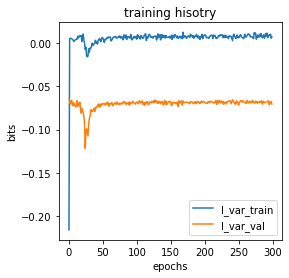

In [18]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [19]:
phi = gpmap.x_to_phi(x_test)

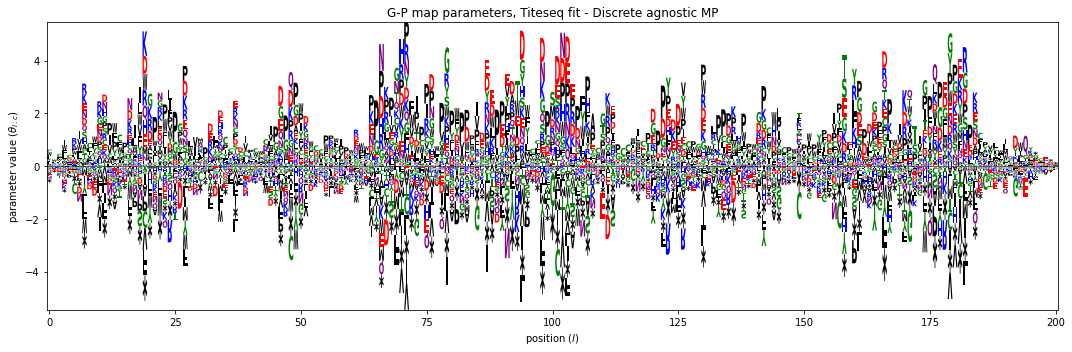

In [20]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete agnostic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DA-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [26]:
sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

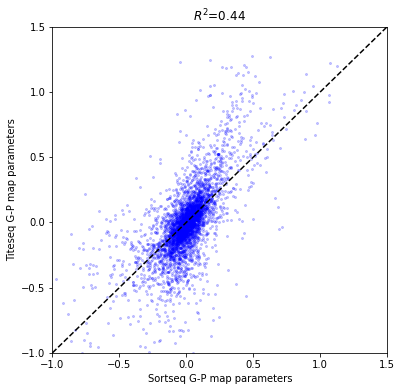

In [28]:
plt.figure(figsize=(6,6))
# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# Style plot
xlim = [-1, 1.5]

plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
plt.xlabel('Sortseq G-P map parameters')
plt.ylabel('Titeseq G-P map parameters')
plt.title(f'$R^2$={Rsq:.3}');
plt.plot(xlim, xlim, '--', color='k', label='diagonal')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

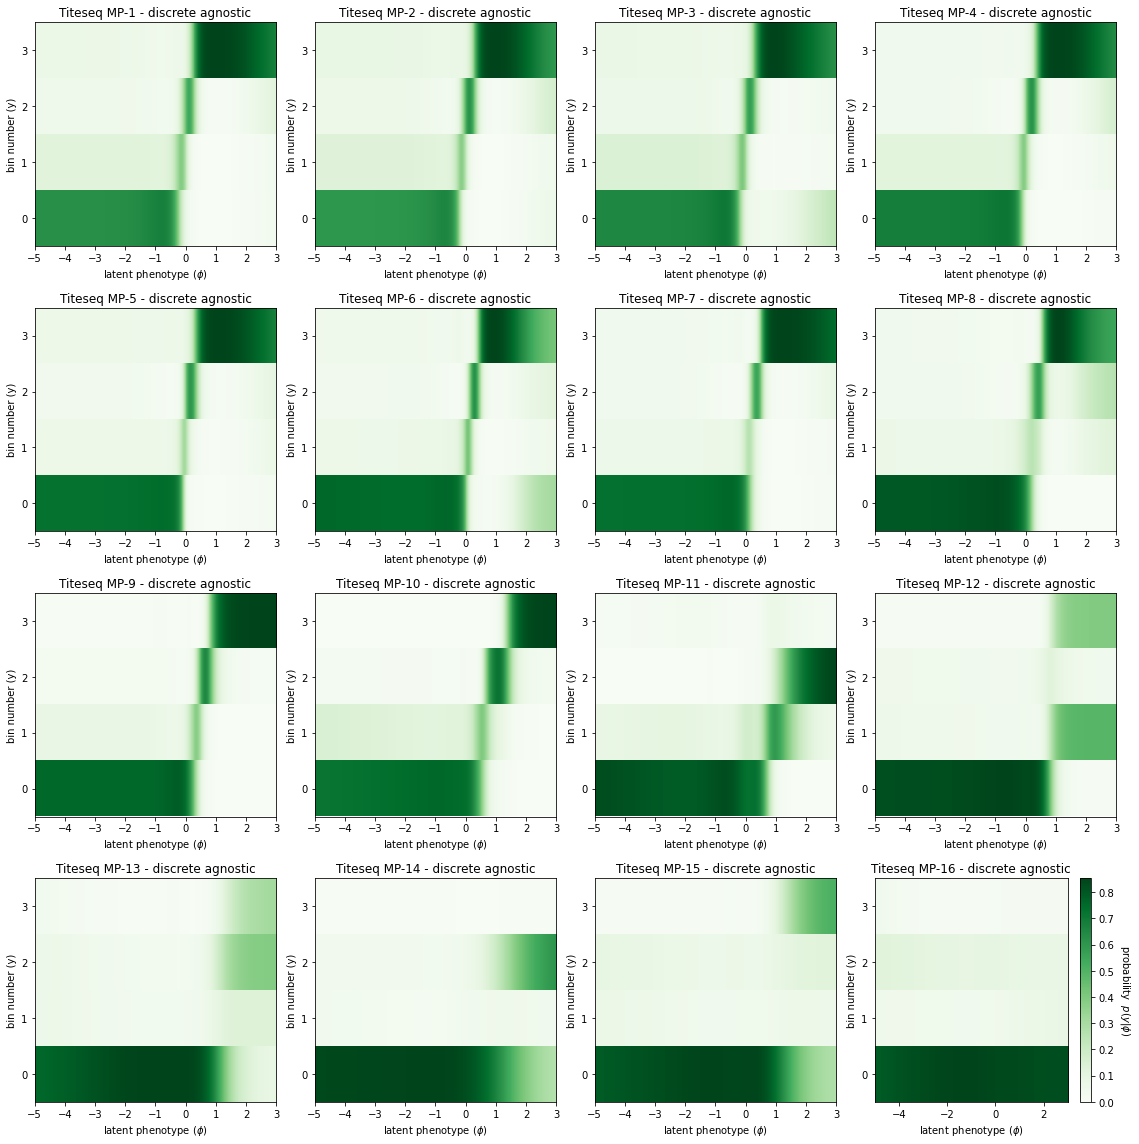

In [29]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, -phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete agnostic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('ace2rbd_mpa_measurment_prcoess_expression.png',dpi=300,bbox_inches='tight')
